# Part 3: Projections for Start/Sit Decisions 

To assess whether projections can be used in start/sit decisions, I will test whether we perform better than an n-sided coin flip when we choose the highest projected player from a list of 2, 3, and 4 players to start at the flex position. 

A reasonable heuristic to determine whether a start/sit decision is non-trivial based on their projections is when players are projected to score within 3 points of each other. That is, the difference between the highest and lower projected player is 3. Based on our analysis around the precision of projections, we know ESPN projection are only accurate within +/- 3 points 31% of the time. 

As shown below, our combinations generate up to tens of millions of comparisons so we will need to carefully optimizing for performance.

Ultimately we conclude that projections create between a 5 and 6% edge versus random.

### generate flex players

In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations

with open(r'data/projections_2020_thru_wk_14_ppr.json', 'r') as f:
    jsons = json.load(f)

In [3]:
recs = pd.DataFrame(jsons)
recs.shape

(5628, 5)

In [4]:
idxs = []
for k, v in [('QB', 10), ('RB', 5), ('WR', 8), ('TE', 5)]:
    hold = recs.loc[(recs['position'] == k) & (recs['projected'] >= v)]
    print('Approximate number of players per week for {}: {}, min: {}'.format(k, int(hold.groupby(by='week')['projected'].count().mean()), hold.groupby(by='week')['projected'].count().min()))
    idxs = idxs + list(hold.index.values)
len(idxs)

Approximate number of players per week for QB: 29, min: 27
Approximate number of players per week for RB: 54, min: 48
Approximate number of players per week for WR: 63, min: 58
Approximate number of players per week for TE: 21, min: 17


2360

In [5]:
recs = recs.iloc[idxs]
print(recs.shape)
recs['prmp'] = recs['projected'] - recs['points']
flex = recs.loc[recs['position'].isin(['RB', 'WR', 'TE'])].copy()

(2360, 5)


### optimizing performance: part 1, combinations function
We are iterating through each player/week combination and, depending on the projection window size, computing combinations of up to n=100 choose k=4. We also need to store each unique combination to ensure we are not checking it twice based on the algorithm we've chosen. This results in # players * # weeks * n choose k time complexity. This could become intractable very quickly so we may need to do random samples instead. Let's investigate that further. 

In [6]:
%timeit list(combinations([1,2,3, 4], r=3))

641 ns ± 68.4 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [7]:
%timeit list(combinations(range(50), r=3))

1.35 ms ± 113 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [8]:
# this took around 22 seconds and froze my compute so avoiding re-running this
#%timeit list(combinations(range(500), r=3))

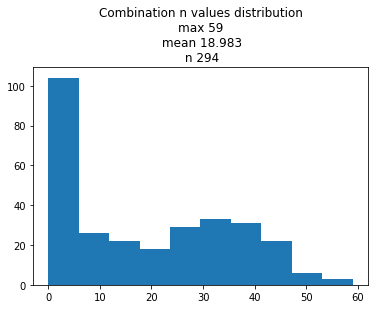

In [9]:
pw = 15
pw_size = 3
win_size = []
for wk in range(1, recs.week.max()+1):
    for pw in np.arange(5, 26, 1):
        win_size.append(len(flex.loc[(flex['week'] == wk) & (flex['projected'] >= pw) & (flex['projected'] < pw + pw_size)]))

plt.title('Combination n values distribution\nmax {}\n mean {}\n n {}'.format(max(win_size), np.round(sum(win_size)/len(win_size), 3), len(win_size)))
plt.hist(win_size, bins='auto')
plt.show()

Let's analyze the cost of computing these combinations using the maximum window size of 4. 

In [10]:
win_pl = 4
%timeit list(combinations(range(19), r=win_pl))

224 µs ± 12.8 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [11]:
%timeit list(combinations(range(59), r=win_pl))

50 ms ± 6.66 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
# 40.3 ms, output above for 59 choose 4 may vary
294*40.3/1000

11.848199999999999

Looks like we should be OK. Even if every window was the max, it'd take us less than a second. We will also want to check the list for every combination. How big is that list?

In [13]:
max_combos = set(combinations(range(59), r=win_pl))
len(max_combos)

455126

We will use hashing for these checks which is included in the Python's implementation of `set`. 

### optimizing performance: part 2, combination loop
these combinations are computed up to 10s of millions of times so we need to be very careful what operations we include. unfortunately pandas `.loc` function is over 10x slower than our `numpy` function and 1000x slower than our built-in operations

In [21]:
def check_wins(pw, size):
    """Generate a list of lower and upper bounds corresponding to all windows +/- size. 
    For example, pw=8 & size=3 generates [5, 8] ... [8, 11]."""
    lb = pw - size
    ub = pw
    for x in np.arange(size+1):
        yield tuple([lb+x, ub+x])

In [22]:
def check_top_projection_fast(X, proj=0, pt=1):
    """Check whether the top projected player scored the most points. Return nan if there are two or more top 
    projected players."""
    X = X[X[:,proj].argsort()]
    if X[-1, proj] == X[-2, proj]:
        return np.nan
    return np.max(X[:, pt]) == X[np.argmax(X[:, proj]), pt]

In [23]:
from numpy.random import default_rng
def sample_arr(X, pct, seed=69):
    """Randomly sample pct records without replacements from an array."""
    if pct != 1:
        rng = default_rng(seed=seed)
        return rng.choice(X, replace=False, size=int(len(X)*pct)+1)
    else:
        return X

In [24]:
test = np.array([1,2,3])
%timeit sorted(list(test) + [3])

2.13 µs ± 99.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [25]:
checked = {tuple(range(x, x+3) for x in range(int(1e6)))}
c = [1,2,3,4]
%timeit tuple(c); tuple([1,2,3]) in checked

300 ns ± 5.98 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [26]:
c = [93, 100, 192, 229]
wk_df = flex.loc[flex['week'] == 1].copy()
%timeit wk_df.loc[c]

433 µs ± 15 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [27]:
%timeit check_top_projection_fast(np.array([[6,7], [7,8], [8,9], [9, 10]]))

34.2 µs ± 809 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### run the analysis via `run_test`

`run_test` Performance notes: 
- len(data), win_pj, and win_pl all determine the number of combinations we use
    - based on a 3 point window comparing 4 players, we compute n choose k on a max of n=59 for a given week which produces about half a million combinations *(see analysis on optimizing cost for combinations)*
- as such, all functions computed in the inner-most loop should be carefully assess for performance
    - pandas.loc method is 10x slower than any other operation *(see analysis on optimizing cost for combiation loop)*

In [28]:
def run_test(data, win_pj, win_pl, pct=0.01, seed=69, log=False):
    """Run test to count the number of times the top player of win_pl scores the most points checking against
    all players who are projected within win_pj points of one another.
    
    Args:
        data (pandas.core.frame.DataFrame): input dataframe containing player-week projected and actual data
            required columns are ['name' (str), 'week' (int), 'points' (float), 'projected' (float)]
        win_pj (int): max distance between highest and lowest projection
        win_pl (int): number of players to compare. Greater than 3, you should sample < 1% to ensure it doesn't take more than 
            too long to run.
        pct (float): value on (0, 1]. At pct=1, we will not use sampling. This is probably OK where win_pl in int[2, 3].
        log (bool): whether to print progress

    Returns:
        checked (set[tuple]): sorted permutations (combinations) that have already been checked. we need to sort them 
            since we exclude 1 of the n players from the combinations function.
        results (dict{'res':bool, 'players':list, 'values':np.ndarray, 'week':int}): returns data collected from 
            experiment including whether the top projected player was the top scorer, the df index values of the
            player-week record, the values compared, and the week of the data
        i (int): returns the number of times a combination was already checked
        
    Performance notes: 
        - len(data), win_pj, and win_pl all determine the number of combinations we use
            - based on a 3 point window comparing 4 players, we compute n choose k on a max of n=59 for a given week
            which produces about half a million combinations
        - as such, all functions computed in the inner-most loop should be carefully assess for performance
          - pandas.loc method is 10x slower than any other operation
    """

    checked = set()
    results = []
    bad_results = []
    i = 0

    for wk in range(1, data.week.max()+1):
        wk_df = data.loc[data['week'] == wk].copy()
        for nm in wk_df.name.sort_values():
            plyr = data.loc[(data['name'] == nm) & (data['week'] == wk)].reset_index().to_dict(orient='records')[0]
            for l, u in check_wins(plyr['projected'], win_pj):
                combos = data.loc[(data['name'] != nm) & (data['week'] == wk) & (data['projected'] >= l) & (data['projected'] < u)]
                if len(combos) >= win_pl-1:
                    for c in sample_arr(list(combinations(combos.index.values, r=win_pl-1)), pct, seed=seed):  # sample all possible combinations
                        c = sorted(list(c) + [plyr['index']])  # since we exclude plyr_idx from combinations, this isn't always sorted
                        c_tup = tuple(c)
                        if c_tup not in checked:
                            # per the below, this is 10x SLOWER than any other line; if we can fix this we may not need to sample
                            X = wk_df.loc[c, ['projected', 'points']].values  # don't use combos since it doesn't always include the player
                            res = check_top_projection_fast(X)
                            if not np.isnan(res):
                                d = {}; d['res'] = res; d['players'] = c; d['values'] = X; d['week'] = wk; results.append(d)
                            checked.add(c_tup)  # tuples are hashable iterables
                        else:
                            i += 1
        if log:
            print('Week {} completed'.format(str(wk)))
    return checked, results, i

### 4 player comparison

In [18]:
win_pj = 3
win_pl = 4
pct = 0.01

checked, results, i = run_test(flex, win_pj, win_pl, pct=pct, log=True)

Week 1 completed
Week 2 completed
Week 3 completed
Week 4 completed
Week 5 completed
Week 6 completed
Week 7 completed
Week 8 completed
Week 9 completed
Week 10 completed
Week 11 completed
Week 12 completed
Week 13 completed
Week 14 completed


In [19]:
print('number checked: {}, \nnumber of results excludes (same top projection): {}, \nnumber of already checked: {}'.format(len(checked), len(checked)-len(results), i))

number checked: 504361, 
number of results excludes (same top projection): 2731, 
number of already checked: 16098


In [20]:
samples = [x['res'] for x in results]
T = (sum(samples))/len(samples)
T

0.29137412036760163

Since we used a sample, let's test whether the sample statistic is different from $25\%$ at a level that is statistically significant. 

In [29]:
from scipy import stats
print('p-value: {}'.format(stats.binom_test(sum(samples), n=len(samples), p=win_pl**-1, alternative='greater')))

p-value: 0.0


We reject the null hypothesis and conclude that selecting the top projected player will result in performance that is different from random chance, or approximately $29.14\%$ of the time. 

And a 99.9% CI

In [76]:
l = len(samples)
p = sum(samples)/len(samples)
print('99.9% CI for p={} on n={}: [{}, {}]'.format(np.round(p, 4), l, np.round(stats.binom(l, p).ppf(0.0005)/l,4), 
                                  np.round(stats.binom(l, p).ppf(0.9995)/l, 4)))

99.9% CI for p=0.2914 on n=501630: [0.2893, 0.2935]


### 3 player comparison

In [36]:
win_pj = 3
win_pl = 3
pct = 1

checked, results, i = run_test(flex, win_pj, win_pl, pct=pct, log=True)

Week 1 completed
Week 2 completed
Week 3 completed
Week 4 completed
Week 5 completed
Week 6 completed
Week 7 completed
Week 8 completed
Week 9 completed
Week 10 completed
Week 11 completed
Week 12 completed
Week 13 completed
Week 14 completed


In [37]:
print('number checked: {}, \nnumber of results excludes (same top projection): {}, \nnumber of already checked: {}'.format(len(checked), len(checked)-len(results), i))

number checked: 1016748, 
number of results excludes (same top projection): 4302, 
number of already checked: 3174258


In [38]:
samples = [x['res'] for x in results]
T = (sum(samples))/len(samples)
T

0.39077442154939623

Interpretation: When you're picking from 3 players within 3 points, you'll select the top performing player by picking the top projected player $39.10\%$ of the time!

### 2 player comparison

In [39]:
win_pj = 3
win_pl = 2
pct = 1

checked, results, i = run_test(flex, win_pj, win_pl, pct=pct, log=True)

Week 1 completed
Week 2 completed
Week 3 completed
Week 4 completed
Week 5 completed
Week 6 completed
Week 7 completed
Week 8 completed
Week 9 completed
Week 10 completed
Week 11 completed
Week 12 completed
Week 13 completed
Week 14 completed


In [40]:
print('number checked: {}, \nnumber of results excludes (same top projection): {}, \nnumber of already checked: {}'.format(len(checked), len(checked)-len(results), i))

number checked: 58504, 
number of results excludes (same top projection): 129, 
number of already checked: 180501


In [41]:
samples = [x['res'] for x in results]
T = (sum(samples))/len(samples)
T

0.5589550321199144

Interpretation: When you're picking from 2 players within 3 points, you'll select the top performing player by picking the top projected player $55.90\%$ of the time!

### run analysis over 2 years
need another API to fetch pre-2019 data

In [29]:
final = []
for year, week in zip(range(2019,2021), [16,14]):
    with open(r'data/projections_{}_thru_wk_{}_ppr.json'.format(year, week), 'r') as f:
            jsons = json.load(f)

    recs = pd.DataFrame(jsons)
    print(year, recs.shape)

    idxs = []
    for k, v in [('QB', 10), ('RB', 5), ('WR', 8), ('TE', 5)]:
        hold = recs.loc[(recs['position'] == k) & (recs['projected'] >= v)]
        print('Approximate number of players per week for {}: {}, min: {}'.format(k, int(hold.groupby(by='week')['projected'].count().mean()), hold.groupby(by='week')['projected'].count().min()))
        idxs = idxs + list(hold.index.values)

    recs = recs.iloc[idxs]
    flex = recs.loc[recs['position'].isin(['RB', 'WR', 'TE'])].copy()
    print(flex.shape)
    
    for win_pj, win_pl, pct in zip([3]*3, list(range(2,5)), [1, 1, 0.01]):
        print('number of players being compared: {}'.format(win_pl))
        
        checked, results, i = run_test(flex, win_pj, win_pl, pct=pct, log=False)
        samples = [x['res'] for x in results]
        T = (sum(samples))/len(samples)
        print('number checked: {}, \nnumber of results excludes (same top projection): {}, \nnumber of already checked: {}, \nT = {}'.format(len(checked), len(checked)-len(results), i, T))
        d = {}; d['year'] = year; d['last_week'] = week; d['data'] = flex; d['win_pj'] = win_pj; d['win_pl'] = win_pl; d['pct'] = pct; d['data_analysis'] = results; d['statistic'] = T; d['summary'] = (len(checked), len(checked)-len(results), i);
        final.append(d)

2019 (6432, 5)
Approximate number of players per week for QB: 29, min: 25
Approximate number of players per week for RB: 53, min: 44
Approximate number of players per week for WR: 60, min: 49
Approximate number of players per week for TE: 21, min: 18
(2174, 5)
number of players being compared: 2
number checked: 62691, 
number of results excludes (same top projection): 112, 
number of already checked: 193122, 
T = 0.5607312357180524
number of players being compared: 3
number checked: 1056060, 
number of results excludes (same top projection): 3670, 
number of already checked: 3285523, 
T = 0.39842263799541994
number of players being compared: 4
number checked: 506192, 
number of results excludes (same top projection): 2275, 
number of already checked: 15864, 
T = 0.30659612594931307
2020 (5628, 5)
Approximate number of players per week for QB: 29, min: 27
Approximate number of players per week for RB: 54, min: 48
Approximate number of players per week for WR: 63, min: 58
Approximate num

# Conclusion

In [104]:
p2 = np.array([x['statistic'] for x in final if x['win_pl'] == 2] + [1/2])
p3 = np.array([x['statistic'] for x in final if x['win_pl'] == 3] + [1/3])
p4 = np.array([x['statistic'] for x in final if x['win_pl'] == 4] + [1/4])

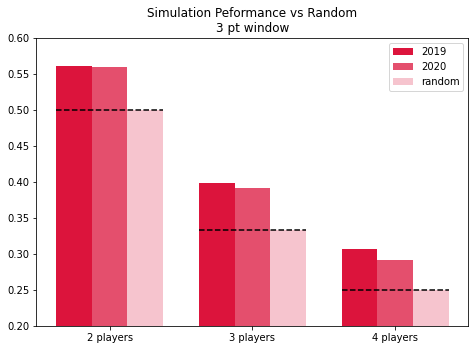

In [117]:
data = np.array([p2, p3, p4]).T
X = np.arange(len(data))
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_xticks(np.arange(0.25, 3.25, 1))
labels = ['2 players', '3 players', '4 players']
ax.set_xticklabels(labels)
ax.plot(np.linspace(-0.125, 0.625, 1000), [0.5]*1000, 'k--')
ax.bar(X + 0.00, data[0], color = 'crimson', alpha=1.0, width = 0.25, label='2019')
#ax.barh(np.linspace(0, 1, 1000))
ax.plot(np.linspace(-0.125+1, 0.625+1, 1000), [1/3]*1000, 'k--')
ax.bar(X + 0.25, data[1], color = 'crimson', alpha=0.75, width = 0.25, label='2020')
ax.plot(np.linspace(-0.125+2, 0.625+2, 1000), [0.25]*1000, 'k--')
ax.bar(X + 0.50, data[2], color = 'crimson', alpha=0.25, width = 0.25, label='random')
plt.ylim(0.2, 0.6)
plt.legend()
plt.title('Simulation Peformance vs Random\n3 pt window')
plt.show()

In [122]:
avgs = np.round(data[:2].mean(axis=0), 3)
avgs

array([0.56 , 0.395, 0.299])

In [124]:
np.round(avgs - np.array([1/2, 1/3, 1/4]), 3)

array([0.06 , 0.062, 0.049])

As shown in the above, we can see that our 2, 3, and 4 player comparisons over a 3 point window perform better than random (black dotted line.) It is pretty consistent across our two season sample. Overall, the deltas create between a 5 and 6% edge versus random. 

It's important to note that this analysis is essentially meaningless since it lacks a baseline: we don't know how other strategies such as starting the top ranked player will perform. The good news is this algorithm is easily transferable to any data set. Getting the data unfortunately, as is frequently the case, is the challenge! 

## odds & ends

### unit tests 
no output is good

In [30]:
# since we exclude plyr_idx from combinations, this isn't always sorted which means set will hash it differently if we don't sort
hold = {tuple(sorted(x['players'])) for x in results}
assert len(hold) == len(results)

In [31]:
# projected, points
assert True == check_top_projection_fast(np.array([[6,7], [7,8], [8,9], [9, 10]]))  # top projected is top points

In [32]:
assert True == check_top_projection_fast(np.array([[10,15], [8,8], [8,9], [9, 10]]))  # top projected is top points

In [33]:
# projected, points
# if top projected is two people, we don't want to make a decision on them
assert np.isnan(check_top_projection_fast(np.array([[6,7], [7,8], [9,9], [9, 10]])))

In [34]:
# projected, points
# top projected is not top
assert False == check_top_projection_fast(np.array([[10,7], [7,8], [9,9], [9, 10]]))

In [35]:
# projected, points
# top projected is not top, however matching projections that are highest are
assert False == check_top_projection_fast(np.array([[10,7], [8,10], [8,10], [7, 9]]))

Our algorithm appears to be working correctly in that it is determining whether the top projected player was the top scorer.

### qc

In [ ]:
win_pj = 3
win_pl = 4
checked = set()
results = []
bad_results = []
pct = 0.01
i=0

for wk in range(1, recs.week.max()+1):
    wk_df = flex.loc[flex['week'] == wk].copy()
    for nm in wk_df.name.sort_values():
        plyr = flex.loc[(flex['name'] == nm) & (flex['week'] == wk)].reset_index().to_dict(orient='records')[0]
        print(wk, plyr['name'])
        for l, u in check_wins(plyr['projected'], win_pj):
            combos = flex.loc[(flex['name'] != nm) & (flex['week'] == wk) & (flex['projected'] >= l) & (flex['projected'] < u)]
            if len(combos) >= win_pl-1:
                for c in sample_arr(list(combinations(combos.index.values, r=win_pl-1)), pct, seed=69):  # sample all possible combinations
                    c = sorted(list(c) + [plyr['index']])  # since we exclude plyr_idx from combinations, this isn't always sorted
                    c_tup = tuple(c)
                    if c_tup not in checked:
                        # per the below, this is 10x SLOWER than any other line; if we can fix this we may not need to sample
                        X = wk_df.loc[c, ['projected', 'points']].values  # don't use combos since it doesn't always include the player
                        res = check_top_projection_fast(X)
                        if np.isnan(res):
                            e = {}; e['players'] = c; e['values'] = X; bad_results.append(e)
                        else:
                            d = {}; d['res'] = res; d['players'] = c; d['values'] = X; d['week'] = wk; results.append(d)
                        checked.add(c_tup)  # tuples are hashable iterables
                    else:
                        i += 1

In [26]:
# results are for seed = 69
print('number checked: {}, \nnumber of results excludes (same top projection): {}, \nnumber of already checked: {}'.format(len(checked), len(checked)-len(results), i))

number checked: 504361, 
number of results excludes (same top projection): 2731, 
number of already checked: 16098


In [70]:
# results are for seed = 69
samples = [x['res'] for x in results]
T = (sum(samples))/len(samples)
T

0.29137412036760163

In [509]:
hold = [rng.integers(0,len(results)) for _ in range(5)]
np.array(results)[hold]

array([{'res': True, 'players': [93, 100, 192, 229], 'values': array([[10.93,  8.2 ],
       [10.82,  2.9 ],
       [12.57, 10.7 ],
       [11.64,  6.6 ]]), 'week': 1},
       {'res': True, 'players': [987, 1005, 1028, 1117], 'values': array([[12.4 ,  8.2 ],
       [12.59, 25.8 ],
       [10.29,  1.  ],
       [11.17,  7.1 ]]), 'week': 3},
       {'res': False, 'players': [4521, 4606, 4611, 4644], 'values': array([[11.75, 17.5 ],
       [11.23, 10.  ],
       [13.  ,  9.3 ],
       [11.91,  7.4 ]]), 'week': 12},
       {'res': True, 'players': [3681, 3703, 3928, 3936], 'values': array([[11.85,  5.7 ],
       [12.32, 10.7 ],
       [11.06,  4.8 ],
       [ 9.64,  2.1 ]]), 'week': 10},
       {'res': False, 'players': [4528, 4532, 4643, 4652], 'values': array([[ 7.28,  1.9 ],
       [ 9.18, 11.6 ],
       [ 9.01, 11.9 ],
       [ 9.55,  5.8 ]]), 'week': 12}], dtype=object)

In [514]:
flex.loc[np.array(results)[hold[4]]['players']]

,name,points,projected,position,week,prmp
4528,Malcolm Brown,1.9,7.28,RB,12,5.38
4532,Frank Gore,11.6,9.18,RB,12,-2.42
4643,Breshad Perriman,11.9,9.01,WR,12,-2.89
4652,Anthony Miller,5.8,9.55,WR,12,3.75
